In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

/tmp/ipykernel_87353/912229180.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


# Wealthfront Data Science Assignment

## SETUP
You work for a lending company that provides small loans to individual borrowers for 3 or 5 years. The company has collected data on the loans granted in the past few years. Your responsibility is to conduct an analysis of the data and retrieve key data insights as described below.
Dataset Description: All the data you need is in the attached CSV file. This table contains the following fields:

    1.	row_id - A unique id for the row
    2.	customer_id — A unique id for the loan borrower
    3.	loan_amount — The amount of the loan requested by the borrower
    4.	funded_amount — The amount of the loan that was actually provided to the borrower
    5.	term — The term of the loan
    6.	interest_rate — The interest rate for the loan
    7.	installment — The monthly payment
    8.	emp_length — Borrower's length of employment at their last job
    9.	home_owner — Borrower's home ownership status
    10.	annual_income — Borrower's annual income
    11.	loan_status — Status of the loan
    12.	purchase — Purpose of the loan
    13.	addr_state — Borrower's state of residence
    14.	dti — Borrower's debt to income ratio
    15.	delinq_2yrs — The frequency of the borrower's credit delinquencies in the last 2 years
    16.	earliest_cr_line — The date the borrower started his/her first credit line (credit card, etc. )
    17.	months_since_last_delinq — The number of months since the borrower was last delinquent on a payment
    18.	open_acc — The number of the borrower's open credit accounts
    19.	revol_bal — The borrower's credit card (i.e. revolving credit line) balance
    20.	total_accounts — The number of the borrower's total credit accounts
    21.	outstanding_principal — Outstanding principal of the loan
    22.	total_payment — Total payment on the loan so far
    23.	total_received_principal — Total principal payments received on the loan so far
    24.	total_received_interest — Total interest payments received on the loan so far
## Tasks:
    •	Implement one or more models to predict whether a loan will be "good" or "bad"
    •	Assess the performance of your models, using statistics or charts as necessary
    •	Discuss the implications of your work and any insights you have uncovered
## Deliverables:
    •	Report -- A summary report of your methodology and findings, including both text and graphs. Maximum 2 pages (excluding figures and tables)
    •	Code -- The code you wrote to conduct the analysis via a public github link (preferred) or plain text files via attachment


# 1. Supervised Learning

## 1.1 Introduction

The purpose of this analysis is to use the available data to predict whether a loan will be *good* or *bad*. After removing missing values, column *loan_status* has seven categories, including *Current*, *Fully Paid*, *In Grace Period*, *Late (31-120 days)*, *Late (16-30 days)*, *Charged Off*, and *Default*. Categories *Fully Paid*, *Charged Off*, and *Default* are the only categories where the end result of a loan is determined. Loans from other categories are still in the middle of their lifetime. In order to group loans into two sections of *good* and *bad*, we assume any loan in categories *Late (31-120 days)*, *Late (16-30 days)*, *Charged Off*, and *Default* is bad. Accordingly, we create a binary variable called *loan_failure* which encompasses this information. With this approach %4.23 of the loans in our data is assumed to be *bad*.

Another assumption that we make here is that we assume we want to make predictions on loan at the begining of the loan course, where no repayment data is available. This assumption would limit the features that we can use in our predictive model. For instance, variables such as *total_pymnt*, *total_rec_prncp* and *total_rec_int* are not accessible when the course of the loan is not started yet.

## 1.2 Data Preparation

After invesitaging the data visually, we run a set of data cleaning and feature engineering. For example, we categorize the *mths_since_last_delinq* column and also we create a new feature called *income_to_inst* which is the ratio of annual income to the monthly payment for each customer.

## 1.3 Feature Selection
We use the Boruta algorithm in the shap-hypetune package to select important features for our task. This algorithm consists of 4 steps:
1. Firstly, it adds randomness to the given data set by creating shuffled copies of all features (called shadow features).
2. Then, it trains a classifier on the extended data set and applies a feature importance measure to evaluate the importance of each feature where higher means more important  SHAP values
3. At every iteration, it checks whether a real feature has a higher importance than the best of its shadow features and constantly removes features which are deemed highly unimportant.
4. Finally, the algorithm stops either when all features gets confirmed or rejected or it reaches a specified limit of runs.

Out of 19 features, this algorithm selects 14 of them and we will include them in our model.

# 1.4 Hyper-parameter Tuning:

We decide to use a GBM model using the lighgbm package to build our predictive model. In order to find the best set of hyper-parameters, we use the Bayesian optimization available in the optuna package, while optimizng our search over higher F1 score, assuming that predicitng both classes correctly is important. We also take into account the unbalanced nature of the data.

# 1.5 Model Evaluation:

In order to assess the model's performance, we look at various metrics including AUC, accuracy, precision, recall, and F1 score on our test data.

************** Performance: Train + Val Set **************** 

Accuracy: 0.66
Precision: 0.08
Recall: 0.69
F1: 0.15


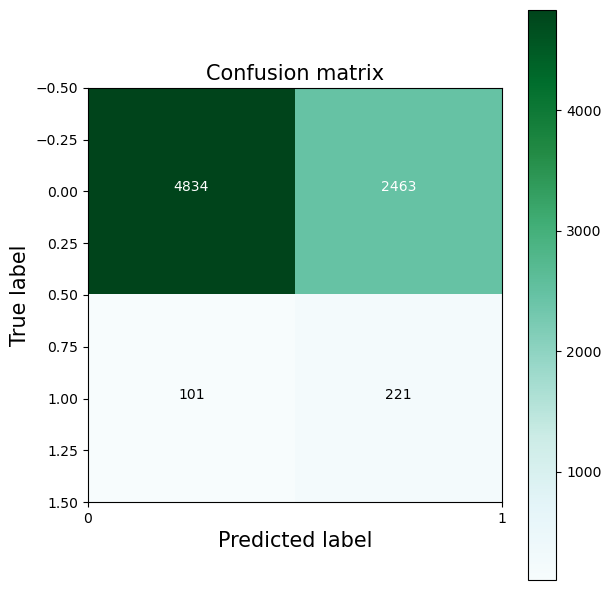

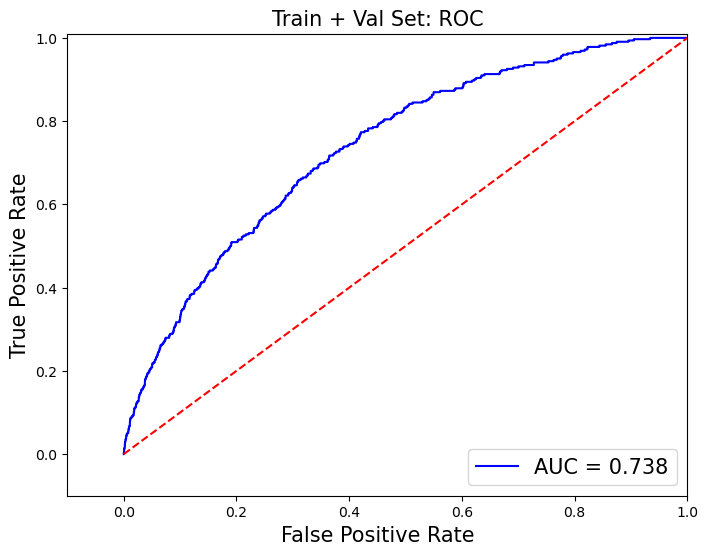

In [29]:
#################################################################
############# Analyze the performance on Train set ##############
#################################################################

perf_analysis(model = gbm_model, data = train_val_df, features = features_impo_bor, y_var = y_var, which_data = 'Train + Val Set')


************** Performance: Test Set **************** 

Accuracy: 0.64
Precision: 0.06
Recall: 0.49
F1: 0.11


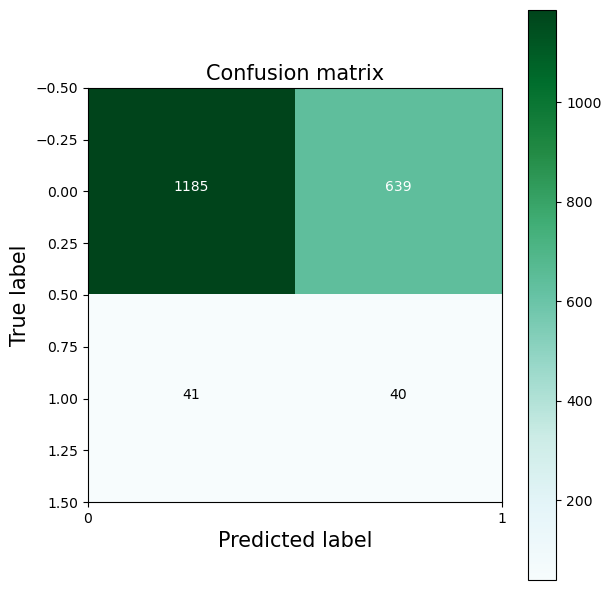

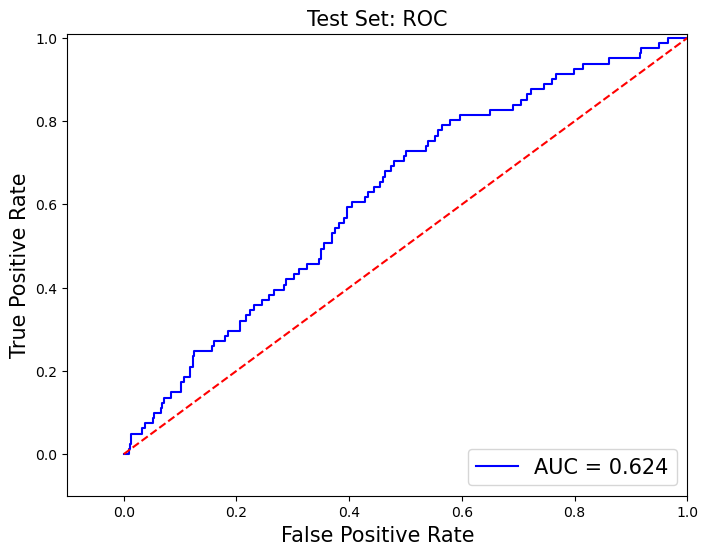

In [30]:
#################################################################
############# Analyze the performance on Train set ##############
#################################################################

perf_analysis(model = gbm_model, data = test_df, features = features_impo_bor, y_var = y_var, which_data = 'Test Set')


# 1.6 Interpretations:

In order to understand the associations between our independent features and the target variable, we look at the SHAP plots and values. The plot below shows that the ration of income to installments, interest rate, and state of residence are predictive of failure likelihood.

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


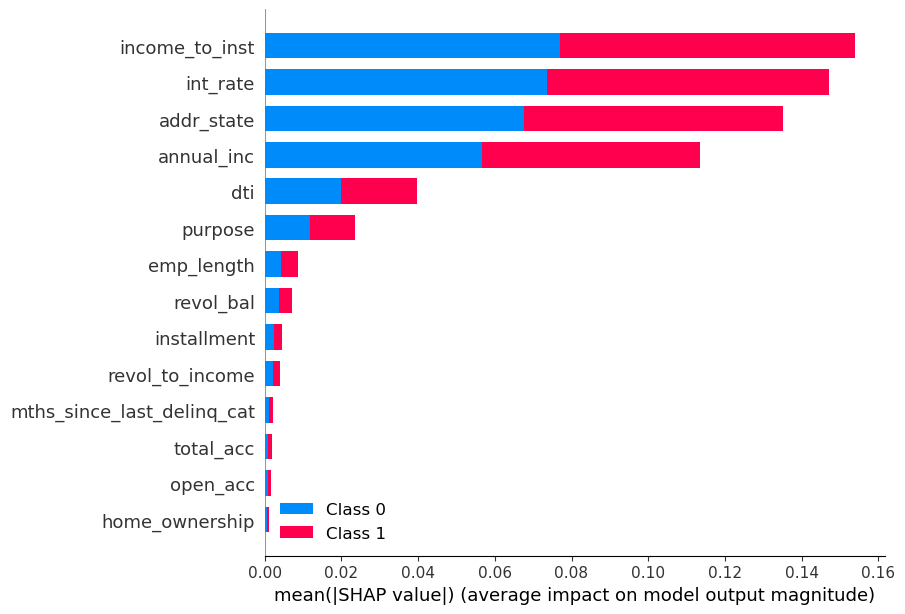

In [32]:
#################################################################
################# Find SHAP values of the model #################
#################################################################

explainer = shap.TreeExplainer(gbm_model)
shap_values = explainer.shap_values(train_val_df[features_impo_bor])

shap.summary_plot(shap_values, train_val_df[features_impo_bor], feature_names = features_impo_bor, max_display = 14)


To take a closer look, we can investigate each variable individually. Below, you can see that interest rate and debt to income ration have a positive relation with loan failure likelihood. Ont the other hand, the number of open accounts and the number of total accounts both have an inverse association with failure likelihood. Moreover, mortgage loans are less likely to fail compared to rent loans.

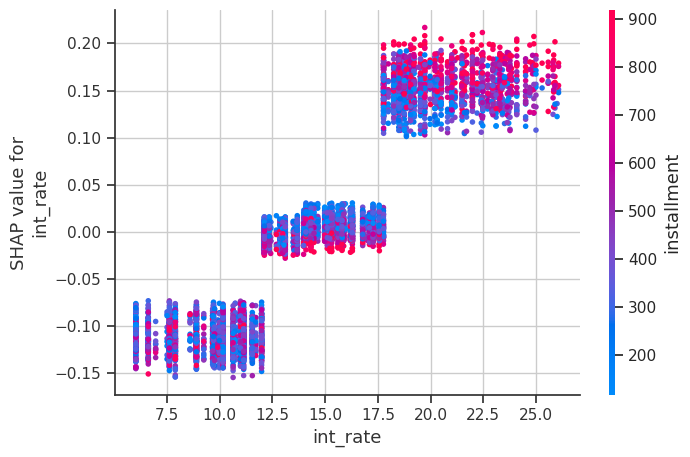

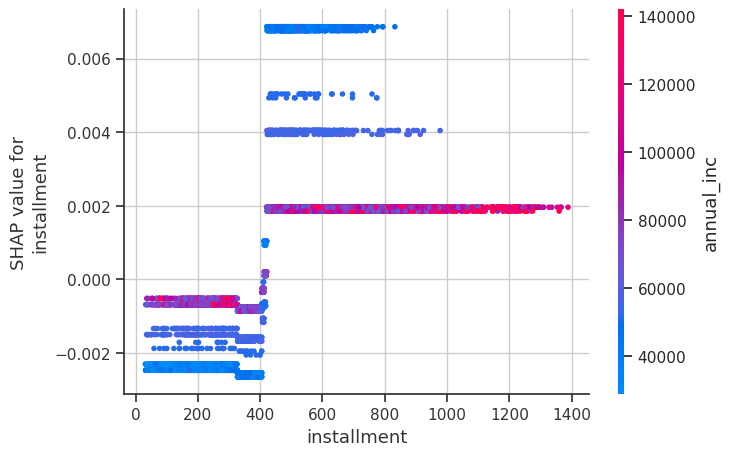

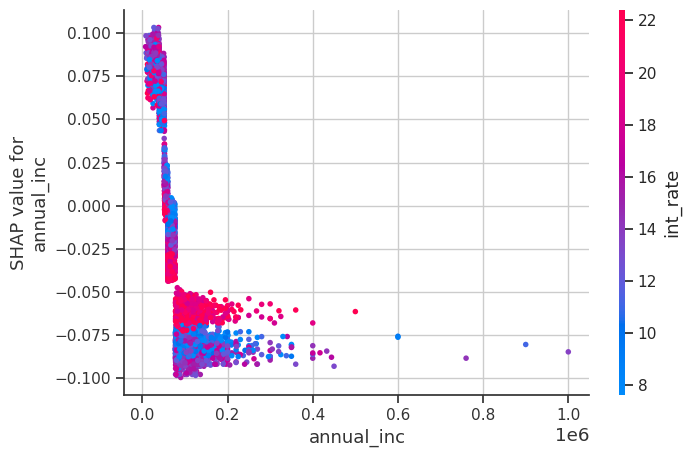

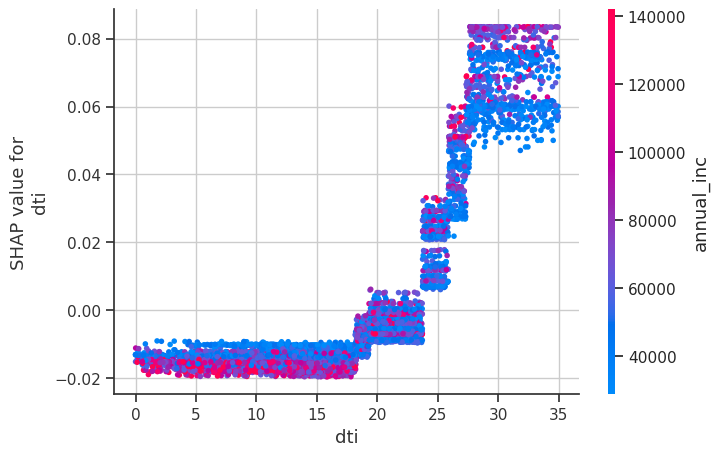

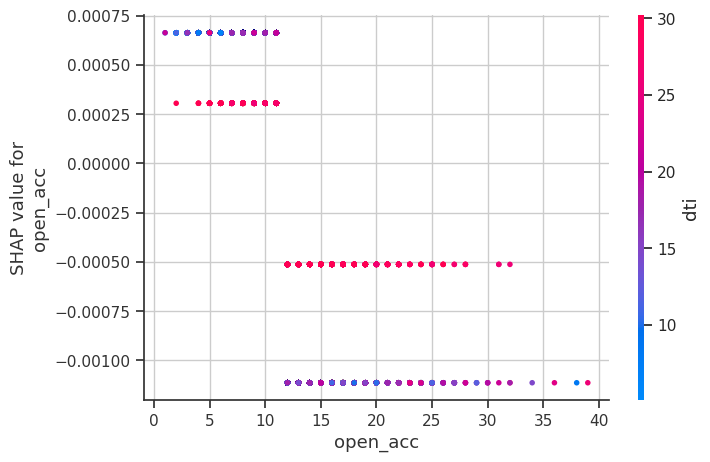

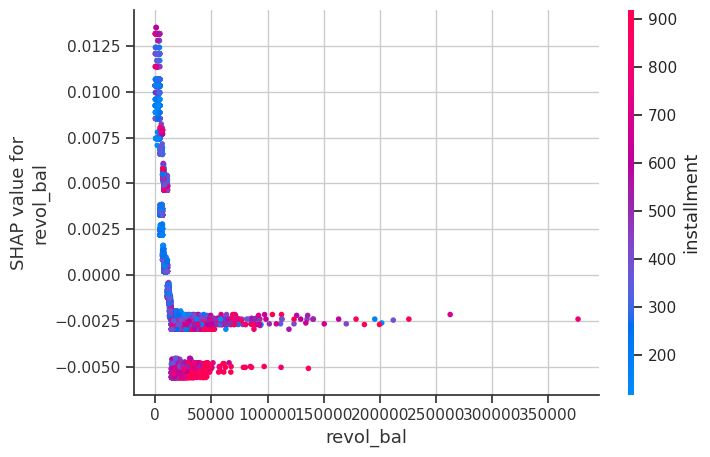

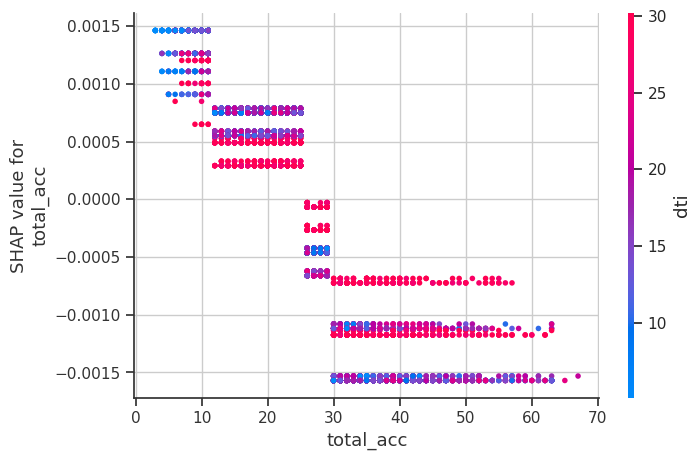

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


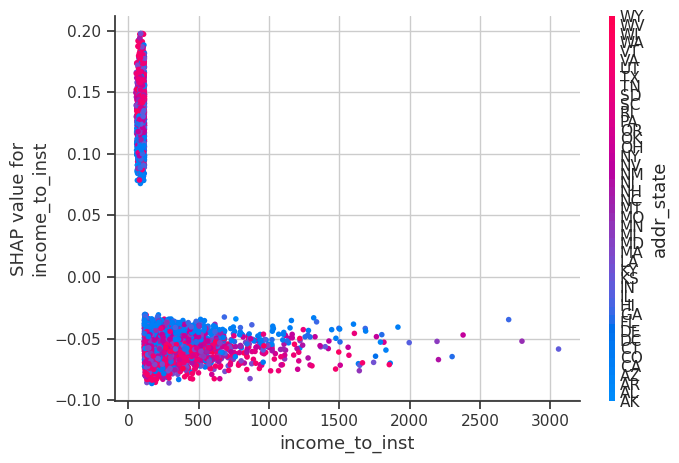

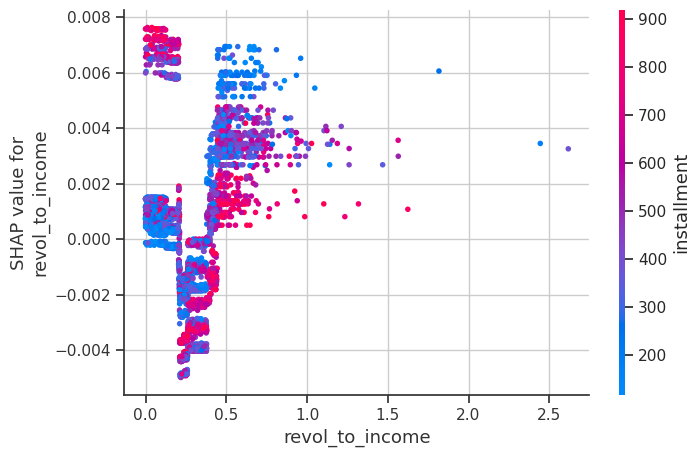

Passing the fontdict parameter of _set_ticklabels() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.


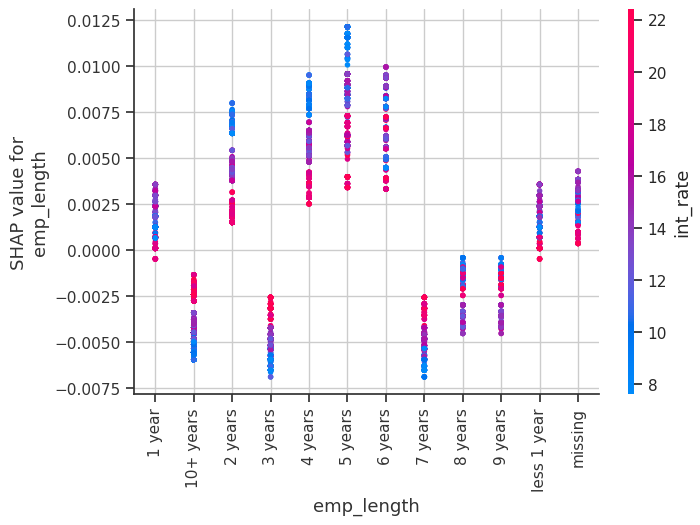

Passing the fontdict parameter of _set_ticklabels() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.


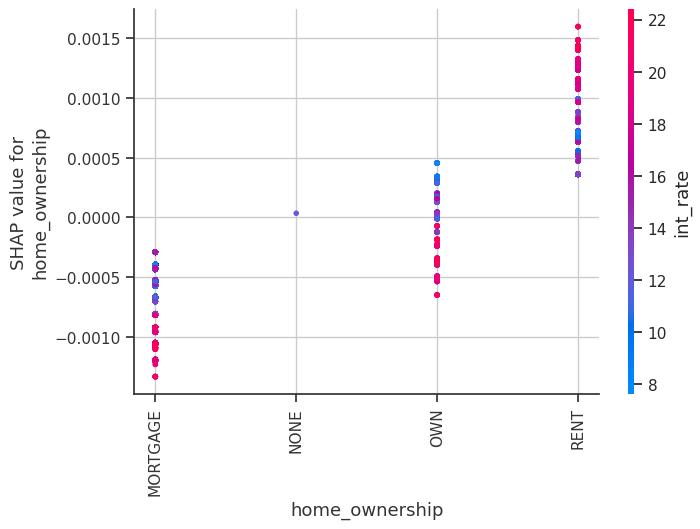

Passing the fontdict parameter of _set_ticklabels() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.


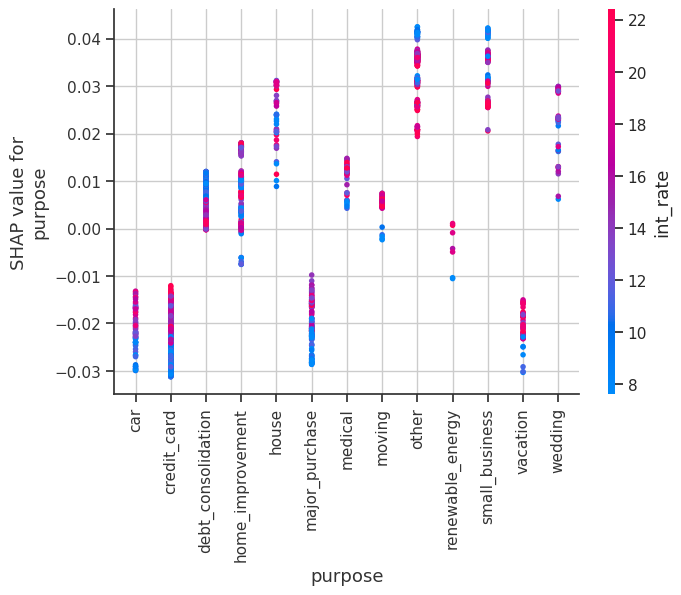

Passing the fontdict parameter of _set_ticklabels() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.


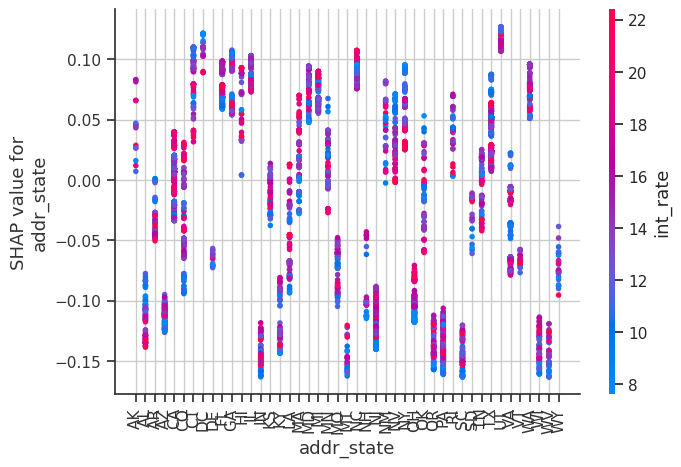

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
Passing the fontdict parameter of _set_ticklabels() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.


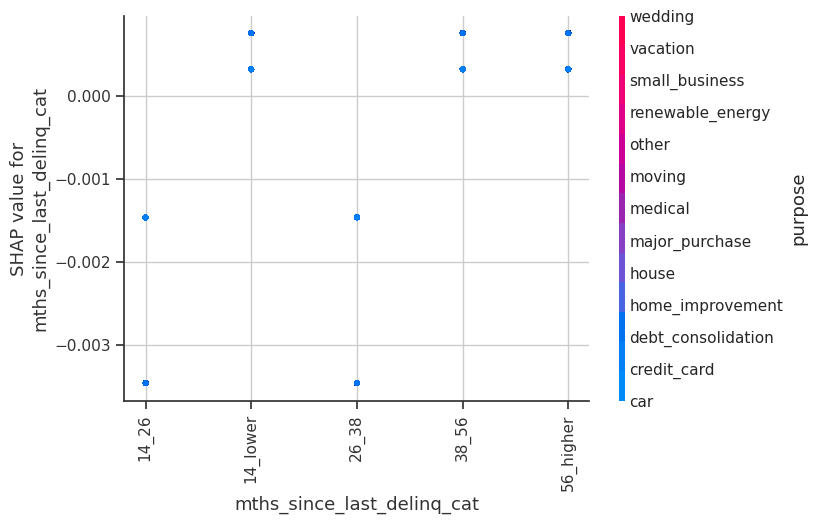

In [136]:
# sort the features indexes by their importance in the model
# (sum of SHAP value magnitudes over the validation dataset)
top_inds = np.argsort(-np.sum(np.abs(shap_values[1]), 0))

# make SHAP plots of the three most important features
for i in range(len(top_inds)):
    shap.dependence_plot(features_impo_bor[i], shap_values[1], train_val_df[features_impo_bor])

# 2. Unsupervised Learning

While we approached this problem from a supervised learning angle, a major limitation of our analysis is that the target variable is not fully realized. In particular, current loans can turn *bad* in the future. Considering this, we hypothesize that loans fall into two clusters based on their initial characteristics: a cluster of loans which fail at some point, and a cluster of loans which will not fail. To find these clusters, we use the k-prototypes algorithm which cal cluster mixed data, including both numerical and categorical.

## 2.1 Data Preparation

We split our data into train and test and normalize our numeric features.

In [60]:
for i in cat_vars:
    df[i] = df[i].astype(str)
    
    
train_df, test_df = train_test_split(
    df, test_size=0.2, random_state=2023, stratify = df[y_var]
)

train_df = train_df.reset_index(drop = True)
test_df = test_df.reset_index(drop = True)

scaler = preprocessing.MinMaxScaler()
train_df[cont_vars] = scaler.fit_transform(train_df[cont_vars])
test_df[cont_vars] = scaler.transform(test_df[cont_vars])

## 2.2 Clustering
We assume there are two clusters in our data. Using the k-prototypes algorithm, we find the clusters on the train set and determine the cluster that each loan belongs to. Cluster 0 contains %38.4 of the data and the reamining belongs to cluster 1. The average failure rate (with the same definiton as in the previous section) in cluster 0 is %4.4, while this number for cluser 1 is %4. Even though the difference is small, but we can say that we found two clusters where one of them is more likely to fail compared to the other one (a quick hypothesis testing can determine the significance of the difference in the proportions). We call them bad and good clusters.

In [95]:
kproto = KPrototypes(n_clusters=2, init='Cao', random_state = 2023)
clusters = kproto.fit_predict(train_df.loc[:, train_df.columns != y_var], categorical=[0, 1, 2, 3, 4, 5])
labels = pd.DataFrame(clusters)
train_df = pd.concat((train_df,labels),axis=1)
train_df = train_df.rename({0:'labels'},axis=1)

In [96]:
train_df['labels'].value_counts(normalize = True, dropna = False)

labels
1    0.61596
0    0.38404
Name: proportion, dtype: float64

In [97]:
agg_df = train_df.groupby(['labels'])[['loan_failure']].mean().reset_index()
agg_df

,labels,loan_failure
0,0,0.044429
1,1,0.040912


Finding the cluster assignments in the test set, we see a similar distribution and differences in terms of failure rate.

In [98]:
clusters = kproto.predict(test_df.loc[:, test_df.columns != y_var], categorical=[0, 1, 2, 3, 4, 5])
labels = pd.DataFrame(clusters)
test_df = pd.concat((test_df,labels),axis=1)
test_df = test_df.rename({0:'labels'},axis=1)

In [99]:
test_df['labels'].value_counts(normalize = True, dropna = False)

labels
1    0.629921
0    0.370079
Name: proportion, dtype: float64

In [100]:
agg_df = test_df.groupby(['labels'])[['loan_failure']].mean().reset_index()
agg_df

,labels,loan_failure
0,0,0.046809
1,1,0.040000


## 2.3 Interpretation:

Let's look at some of the differences between these two clusters. The cluster is more populated with short-term loans compared to the bad cluster. Moreover, loans for debt consolidation purposes are more likely to fail. Looking at some of numeric features, loans in the bad cluster tend to have lower income to installment ratio and higher interest rate.

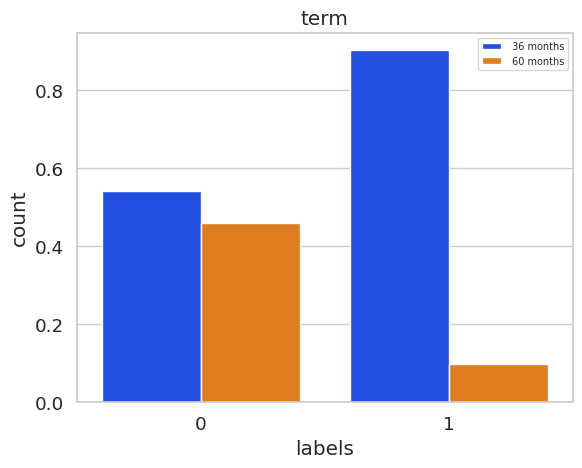

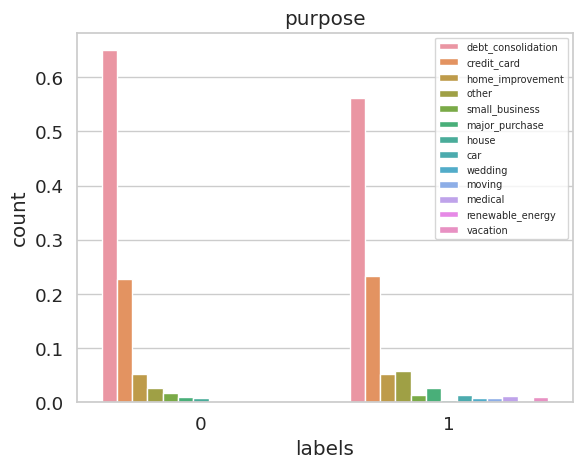

In [180]:
for i in ['term',
         'purpose',
         ]:
    agg_df = pd.DataFrame(train_df.groupby(['labels'])[[i]].value_counts().reset_index())
    agg_df['count'] = agg_df['count']/agg_df.groupby('labels')['count'].transform('sum')
    plt.figure()
    sns.barplot(data=agg_df, x='labels', y='count', hue=i)
    plt.legend(fontsize=7, title_fontsize='40')
    plt.title(i)
    plt.show()

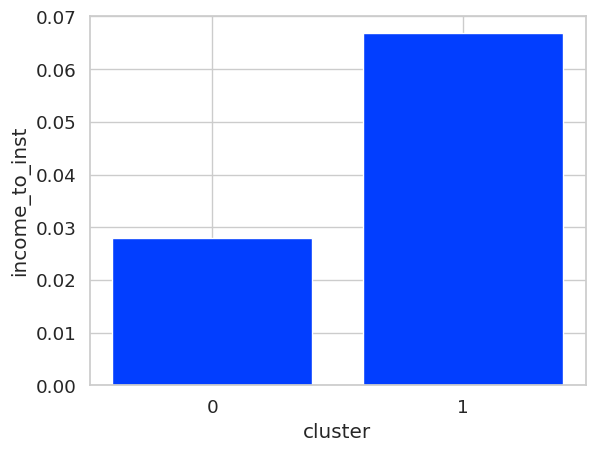

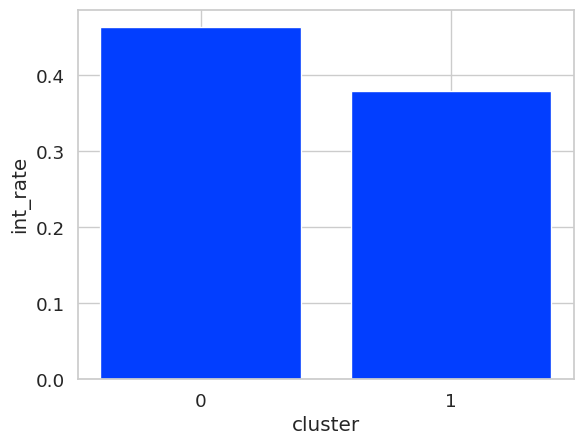

In [148]:
for i in ['income_to_inst', 'int_rate']:
    agg_df = pd.DataFrame(train_df.groupby(['labels'])[[i]].mean().reset_index())
    plt.bar(agg_df['labels'], agg_df[i])
    plt.xlabel('cluster')
    plt.ylabel(i)
    plt.xticks([0,1])
    plt.show()